In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Read in and convert to date to datetime

In [8]:
traffic = pd.read_csv('training_Traffic.csv')

In [9]:
# convert to datatime
traffic['Date'] = pd.to_datetime(traffic['Date'])
traffic.set_index('Date', inplace = True)
traffic.sort_index(inplace = True)
traffic.columns = ['traffic']
traffic.head()

,traffic
Date,
2015-01-01 10:00:00,0
2015-01-01 10:15:00,1
2015-01-01 10:30:00,4
2015-01-01 10:45:00,3
2015-01-01 11:00:00,1


## Explore the data

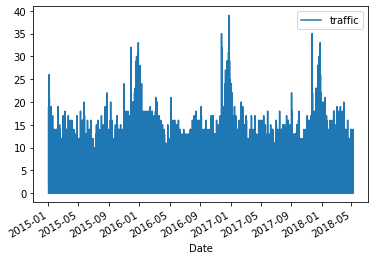

In [10]:
traffic.plot();

 The initial plot is hard to interpret.  There seems to be some spikes, and one very large traffic day

In [11]:
#Since we are predicting June 2018 look at June 2017
prev_month_total = traffic['2017-06'].resample('d').sum().dropna()
prev_month_total

,traffic
Date,
2017-06-01,135
2017-06-02,170
2017-06-03,260
2017-06-04,209
2017-06-05,154
2017-06-06,140
2017-06-07,146
2017-06-08,150
2017-06-09,178


In [12]:
prev_month_total.describe()

,traffic
count,30.000000
mean,176.766667
std,40.686084
min,128.000000
25%,144.500000
50%,167.000000
75%,192.750000
max,280.000000


In [13]:
#look at the mean traffic for each day of the previous years month
prev_month_mean = traffic['2017-06'].resample('d').mean().dropna()
prev_month_mean.describe()

,traffic
count,30.000000
mean,3.740784
std,1.087887
min,2.415094
25%,2.906250
50%,3.392390
75%,4.286902
max,6.026316


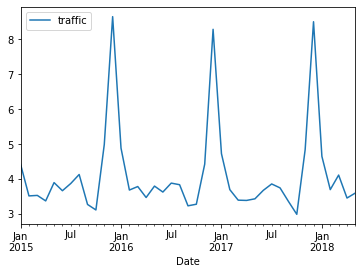

In [14]:
traffic_month = traffic.resample('M').mean()
traffic_month.plot();

Unlike sales the traffic is pretty consistent across the month of December

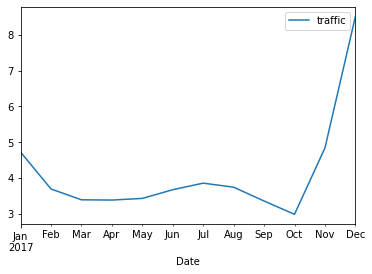

In [15]:
traffic_2017 = traffic['2017'].resample('M').mean()
traffic_2017.plot();

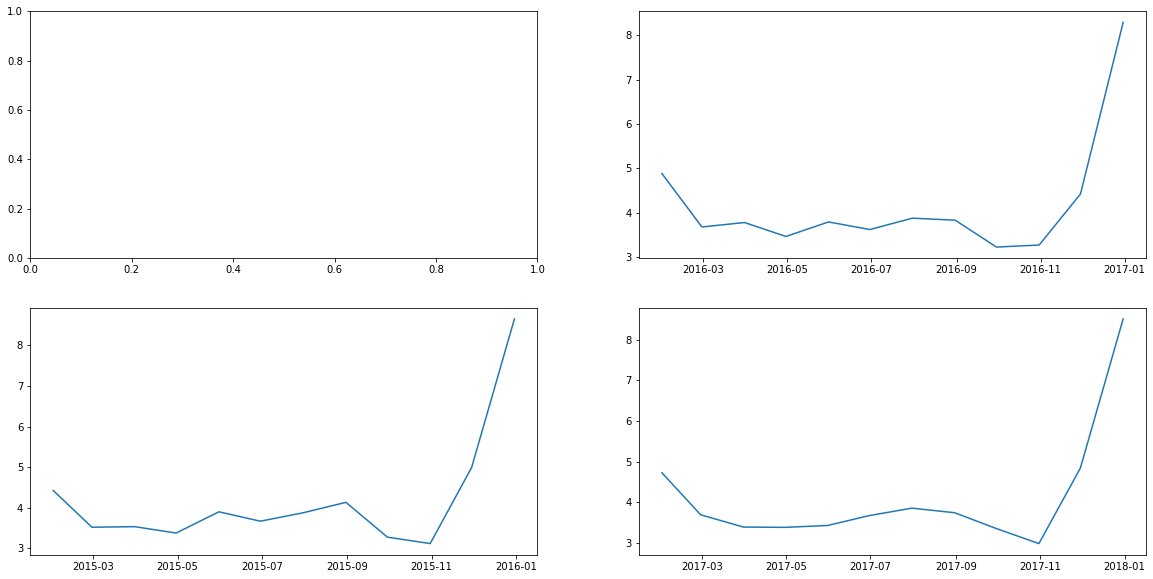

In [16]:
fig, ax = plt.subplots(2,2, figsize=(20,10))


#ax[0,0].plot(traffic['2014'].resample('M').mean())

ax[1,0].plot(traffic['2015'].resample('M').mean())
ax[0,1].plot(traffic['2016'].resample('M').mean())
ax[1,1].plot(traffic['2017'].resample('M').mean())
plt.show();

Investigating the other 3 cyclic spikes in traffic they appear to be every August and then in early spring/summer (April, May, or June) and at the begining of the year in February.

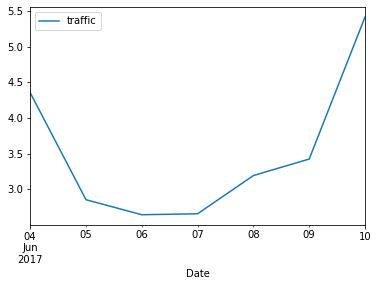

In [17]:
#What does a typical week look like (Sunday to Saturday)
traffic_2017_week = traffic.loc['2017-06-04': '2017-06-10'].resample('D').mean()
traffic_2017_week.plot();

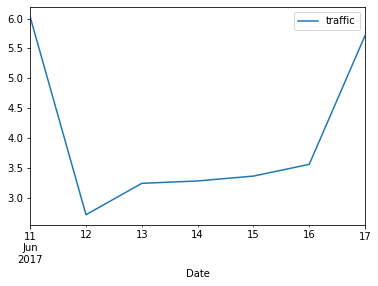

In [18]:
traffic_2017_week = traffic.loc['2017-06-11': '2017-06-17'].resample('D').mean()
traffic_2017_week.plot();

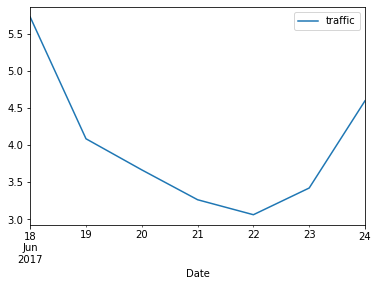

In [19]:
traffic_2017_week = traffic.loc['2017-06-18': '2017-06-24'].resample('D').mean()
traffic_2017_week.plot();

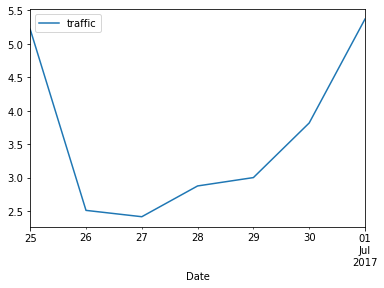

In [20]:
traffic_2017_week = traffic.loc['2017-06-25': '2017-07-01'].resample('D').mean()
traffic_2017_week.plot();

### Looking at each week from the previous year (2017) for the month of June we see strongest traffic on Sunday and weakest traffic Monday and Tuesday with a general recovery toward the end of the week

In [21]:
# number of days in dataset
unique_days = traffic.index.normalize().value_counts()
unique_days

2016-11-25    72
2015-11-27    71
2016-12-21    70
2017-12-20    70
2016-12-23    68
              ..
2018-02-11    34
2017-07-09    34
2016-11-24    10
2015-11-26     8
2017-11-23     4
Name: Date, Length: 1215, dtype: int64

### Find min and max time looking for typical store hours

In [22]:
#original thought was looking for store core hours.  Look at how many rows match each hour
match = "19:00:00"
traffic.loc[traffic.index.strftime("%H:%M:%S") == match]

,traffic
Date,
2015-01-01 19:00:00,2
2015-01-02 19:00:00,10
2015-01-03 19:00:00,8
2015-01-04 19:00:00,3
2015-01-05 19:00:00,1
...,...
2018-05-02 19:00:00,2
2018-05-03 19:00:00,2
2018-05-04 19:00:00,5


In [23]:
traffic.shape

(58437, 1)

In [24]:
traffic.describe()

,traffic
count,58437.000000
mean,4.208755
std,4.059862
min,0.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,39.000000


### Resample to hourly

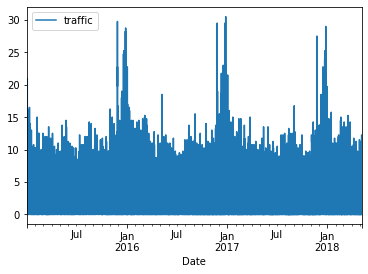

In [25]:
#Because we are projecting every hour we will resample to be in the same units
traffic_rs = traffic.resample('H').mean()
traffic_rs.plot();

In [26]:
traffic_rs.head()

,traffic
Date,
2015-01-01 10:00:00,2.00
2015-01-01 11:00:00,3.50
2015-01-01 12:00:00,7.00
2015-01-01 13:00:00,8.25
2015-01-01 14:00:00,11.75


As we can see this created a lot of null values

In [27]:
traffic_rs.shape

(29316, 1)

In [28]:
traffic_rs.isna().sum()

traffic    11566
dtype: int64

In [29]:
#check number of nulls in core hours
traffic_rs_day = traffic_rs.between_time('11:00:00' , '19:00:00')
traffic_rs_day.isna().sum()

traffic    94
dtype: int64

In [30]:
traffic_rs.head()

,traffic
Date,
2015-01-01 10:00:00,2.00
2015-01-01 11:00:00,3.50
2015-01-01 12:00:00,7.00
2015-01-01 13:00:00,8.25
2015-01-01 14:00:00,11.75


In [31]:
traffic_rs.isna().sum()

traffic    11566
dtype: int64

In [32]:
traffic_rs.dropna(inplace=True)

In [33]:
traffic_rs.shape

(17750, 1)

In [34]:
traffic_rs.isna().sum()

traffic    0
dtype: int64

### Is the Data Stationary??

In [35]:
#Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adfuller(traffic_rs)

(-14.40210571954656,
 8.475001424568906e-27,
 44,
 17705,
 {'1%': -3.4307194012057134,
  '5%': -2.8617032611843674,
  '10%': -2.5668568996699093},
 65789.5502785867)

In [37]:
#The p-value is the second value: 8.47 e-27
#This is sufficiently below .05 and the data does not need to be diff for stationarity

## Look at Autocorrelation and P ACF

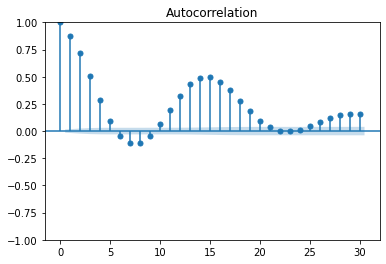

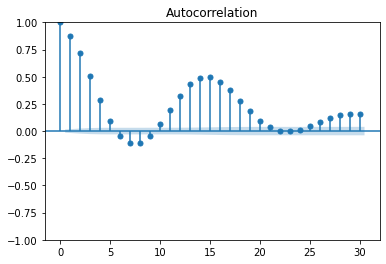

In [110]:
plot_acf(traffic_rs['traffic'], lags = 30)

C:\Users\eswan\anaconda3\envs\projects\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


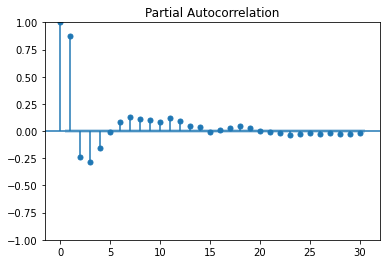

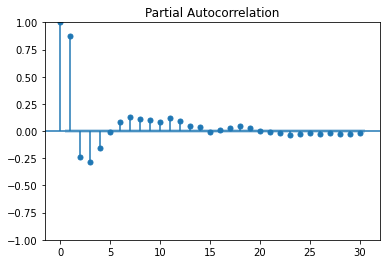

In [37]:
plot_pacf(traffic_rs['traffic'], lags = 30)

## Base Model

In [38]:
#forecast using the dataset mean since we are projecting so much data into the future
base_model = traffic.copy()
base_model['forecast_traffic'] = 4.2
base_model.head()

,traffic,forecast_traffic
Date,,
2015-01-01 10:00:00,0,4.2
2015-01-01 10:15:00,1,4.2
2015-01-01 10:30:00,4,4.2
2015-01-01 10:45:00,3,4.2
2015-01-01 11:00:00,1,4.2


In [59]:
base_model_error = mean_squared_error(base_model.traffic, base_model.forecast_traffic)
np.sqrt(base_model_error)

4.05983718993703

## Build the model

## SARIMAX

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
traffic_train = traffic_rs.traffic.loc[:'2018-04-05 19:00:00']
traffic_test = traffic_rs.traffic.loc['2018-04-06 10:15:00': '2018-05-06 19:00:00']

In [126]:
model = SARIMAX(traffic_train, order=(3, 1, 2),
              seasonal_order=(2, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

In [56]:
len(traffic_test)

437

In [95]:
forecast = results.predict(start = len(traffic_train),
                           end=len(traffic_train)+436,
                           typ='levels').rename('Predict')

In [96]:
forecast_df = pd.DataFrame(forecast)
forecast_df.reset_index(drop=True, inplace=True)
forecast_df.head()

,Predict
0,1.971073
1,1.942053
2,1.934067
3,2.883439
4,3.360168


In [97]:
#Create a df with test size values
new = pd.DataFrame(traffic_test)
new['date'] = new.index
new.reset_index(drop=True, inplace=True)
new.head()

,traffic,date
0,3.50,2018-04-06 11:00:00
1,5.25,2018-04-06 12:00:00
2,7.25,2018-04-06 13:00:00
3,8.50,2018-04-06 14:00:00
4,10.75,2018-04-06 15:00:00


In [98]:
len(new)

437

In [99]:
len(forecast_df)

437

In [100]:
results = pd.concat([new, forecast_df], axis=1)

In [101]:
#results.head()
results.set_index('date', inplace=True)

In [102]:
results.head()

,traffic,Predict
date,,
2018-04-06 11:00:00,3.50,1.971073
2018-04-06 12:00:00,5.25,1.942053
2018-04-06 13:00:00,7.25,1.934067
2018-04-06 14:00:00,8.50,2.883439
2018-04-06 15:00:00,10.75,3.360168


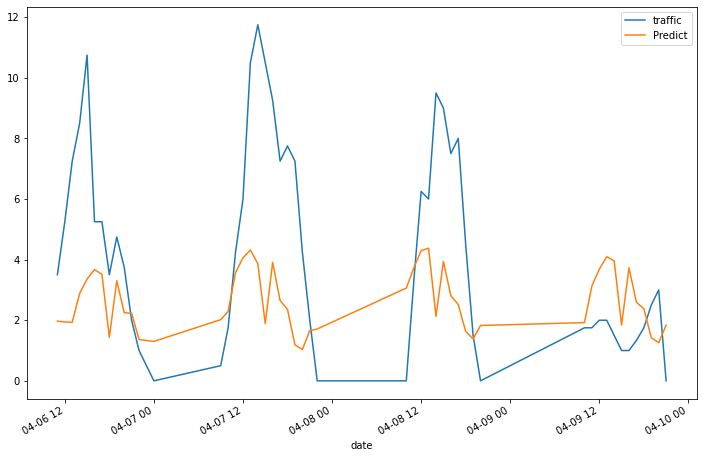

In [103]:
results['traffic'][:50].plot(figsize=(12,8),legend=True)
results['Predict'][:50].plot(legend=True);

In [104]:
mean_squared_error(results['traffic'], results['Predict']) ** 0.5

2.900562036697101

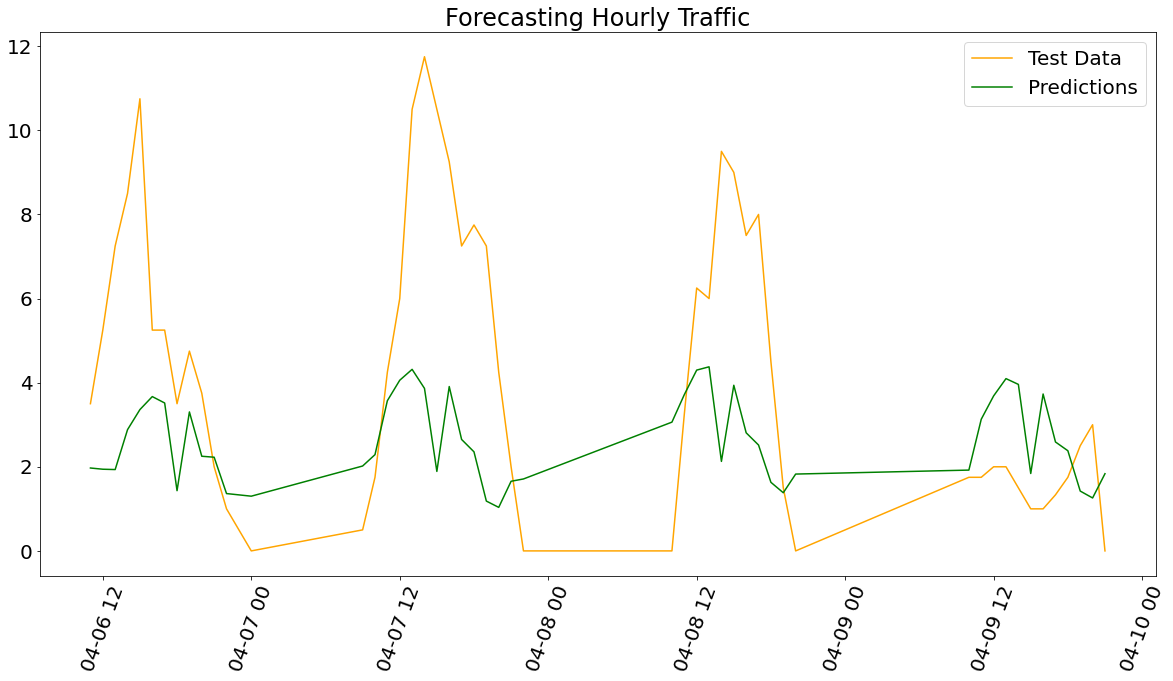

In [105]:
plt.figure(figsize=(20,10))

# Plot testing data.
plt.plot(results['traffic'][:50], color = 'orange', label='Test Data')

# Plot predicted test values.
plt.plot(results['Predict'][:50], color = 'green', label='Predictions')

# Set label.
plt.title(label = 'Forecasting Hourly Traffic', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20,rotation=70)
plt.yticks(fontsize=20)

plt.legend(loc='best', prop={'size': 20});

In [127]:
traffic_forecast_May = results.predict(start = len(traffic_rs),
                           end=len(traffic_rs)+722,
                           typ='levels').rename('Traffic_Predict')

In [128]:
forecast_May_df = pd.DataFrame(traffic_forecast_May)
forecast_May_df.reset_index(drop=True, inplace=True)
forecast_May_df.head()

,Traffic_Predict
0,1.695509
1,1.805804
2,3.070308
3,3.643906
4,4.083385


In [129]:
#Create a dataframe with the dates to forecast
sales_forecast1 = pd.DataFrame({'Hours': pd.date_range('2018-05-06 22:00:00', '2018-06-06', freq='1H', closed='left')})
sales_forecast1.head()

,Hours
0,2018-05-06 22:00:00
1,2018-05-06 23:00:00
2,2018-05-07 00:00:00
3,2018-05-07 01:00:00
4,2018-05-07 02:00:00


In [130]:
results = pd.concat([sales_forecast1, forecast_May_df], axis=1)
results.set_index('Hours', inplace=True)
results.head()

,Traffic_Predict
Hours,
2018-05-06 22:00:00,1.695509
2018-05-06 23:00:00,1.805804
2018-05-07 00:00:00,3.070308
2018-05-07 01:00:00,3.643906
2018-05-07 02:00:00,4.083385


In [131]:
results.to_csv('traffic_prediction.csv')

In [ ]:
#Merge datasets

In [132]:
sales_predictons = pd.read_csv('sales_prediction.csv')
sales_predictons.set_index('Hours', inplace=True)
sales_predictons.head()

,Sales_Predict
Hours,
2018-05-06 22:00:00,797.555908
2018-05-06 23:00:00,768.167698
2018-05-07 00:00:00,801.929601
2018-05-07 01:00:00,774.347994
2018-05-07 02:00:00,776.050799


In [133]:
Final_prediction = pd.concat([results, sales_predictons], axis=1)
Final_prediction.head()

,Traffic_Predict,Sales_Predict
Hours,,
2018-05-06 22:00:00,1.695509,797.555908
2018-05-06 23:00:00,1.805804,768.167698
2018-05-07 00:00:00,3.070308,801.929601
2018-05-07 01:00:00,3.643906,774.347994
2018-05-07 02:00:00,4.083385,776.050799


In [134]:
Final_prediction.to_csv('final_sales_traffic_preds.csv')